# LIBRARIES

In [15]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from imageio import imread

# IDENFITY ACTUAL BOXES

In [2]:
vgg = tf.keras.applications.VGG16(input_shape=[100, 100, 3], include_top=False, weights='imagenet')

In [3]:
x     = Flatten()(vgg.output)
x     = Dense(4, activation='sigmoid')(x)
model = Model(vgg.input, x)

In [4]:
def image_generator(batch_size=64):
    # Generate image and targets
    while True:
        # Each epoch will have 50 batches
        for _ in range(50):
            X = np.zeros(shape=(batch_size, 100, 100, 3))
            Y = np.zeros(shape=(batch_size, 4))
            
            # Make the boxes and store their location in target
            for i in range(batch_size):
                row0 = np.random.randint(90)
                col0 = np.random.randint(90)
                row1 = np.random.randint(low=row0, high=100)
                col1 = np.random.randint(low=col0, high=100)
                # Images
                X[i, row0:row1, col0:col1, :] = 1
                # Targets
                Y[i, 0] = row0 / 100.           # Top left
                Y[i, 1] = col0 / 100.           # Top left
                Y[i, 2] = (row1 - row0) / 100.  # Height
                Y[i, 3] = (col1 - col0) / 100.  # Width
            
            yield X, Y

In [5]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
model.fit(x=image_generator(), steps_per_epoch=50, epochs=5)

C:\Users\Doan Trong Hieu\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
50/50 [==============================] - 307s 6s/step - loss: 0.6256
Epoch 2/5
50/50 [==============================] - 329s 7s/step - loss: 0.5171
Epoch 3/5
50/50 [==============================] - 300s 6s/step - loss: 0.5085
Epoch 4/5
50/50 [==============================] - 273s 5s/step - loss: 0.5071
Epoch 5/5
50/50 [==============================] - 279s 6s/step - loss: 0.5040


In [7]:
from matplotlib.patches import Rectangle

# Make predictions
def make_predictions():
    # Generate a random image
    x    = np.zeros(shape=(100, 100, 3))
    row0 = np.random.randint(90)
    col0 = np.random.randint(90)
    row1 = np.random.randint(low=row0, high=100)
    col1 = np.random.randint(low=col0, high=100)
    x[row0:row1, col0:col1, :] = 1
    print(row0, col0, row1, col1)
    
    # Predict
    X = np.expand_dims(x, 0)
    p = model.predict(X)[0]
    
    # Draw the box
    fig, ax = plt.subplots(1)
    ax.imshow(x)
    # Top left, Width, Height
    rect = Rectangle((p[1] * 100, p[0] * 100), p[3] * 100, p[2] * 100, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

59 59 95 96


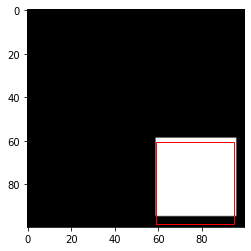

In [8]:
make_predictions()

# LOCATE AN ACTUAL OBJECT

In [12]:
# !wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

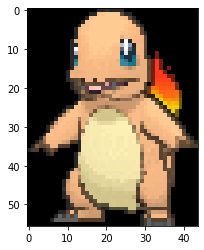

In [13]:
ch = image.load_img('charmander-tight.png')
plt.imshow(ch)
plt.show()

In [14]:
np.array(ch).shape

(56, 44, 3)

<class 'imageio.core.util.Array'>
(56, 44, 4)


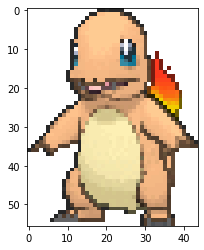

In [18]:
ch = imread('charmander-tight.png')
plt.imshow(ch)
print(type(ch))
print(ch.shape)

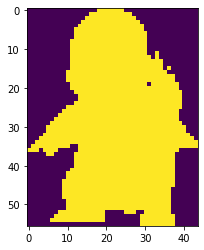

In [19]:
# Plot the alpha channel
plt.imshow(ch[:, :, 3])
plt.show()

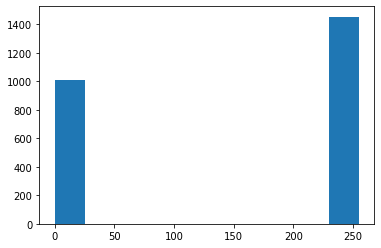

{0, 255}

In [20]:
plt.hist(ch[:, :, 3].flatten())
plt.show()
set(ch[:, :, 3].flatten())

In [23]:
POKE_DIM      = 200 # Size of image 
ch            = np.array(ch)
CH_H, CH_W, _ = ch.shape

def pokemon_generator(batch_size=64):
    # Generate image and targets
    while True:
        # Each epoch will have 50 batches
        for _ in range(50):
            X = np.zeros(shape=(batch_size, POKE_DIM, POKE_DIM, 3))
            Y = np.zeros(shape=(batch_size, 4))
            
            # Make the boxes and store their location in target
            for i in range(batch_size):
                row0 = np.random.randint(POKE_DIM - CH_H)
                col0 = np.random.randint(POKE_DIM - CH_W)
                row1 = row0 + CH_H
                col1 = col0 + CH_W
                # Images
                X[i, row0:row1, col0:col1, :] = ch[:, :, :3]
                # Targets
                Y[i, 0] = row0 / POKE_DIM           # Top left
                Y[i, 1] = col0 / POKE_DIM           # Top left
                Y[i, 2] = (row1 - row0) / POKE_DIM  # Height
                Y[i, 3] = (col1 - col0) / POKE_DIM  # Width
            
            yield X / 255., Y

In [ ]:
def make_model():
    vgg   = tf.keras.applications.VGG16(input_shape=[POKE_DIM, POKE_DIM, 3],
                                        include_top=False, weights='imagenet')
    x     = Flatten()(vgg.output)
    x     = Dense(units=4, activation='sigmoid')(x)
    model = Model(vgg.input, x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))
    
    return model

model = make_model()
model.fit(x=pokemon_generator(), steps_per_epoch=50, epochs=5)

Epoch 1/5
41/50 [=======================>......] - ETA: 3:31 - loss: 0.6819

In [ ]:
from matplotlib.patches import Rectangle

# Make predictions
def make_predictions():
    # Generate a random image
    x    = np.zeros(shape=(POKE_DIM, POKE_DIM, 3))
    row0 = np.random.randint(POKE_DIM - CH_H)
    col0 = np.random.randint(POKE_DIM - CH_W)
    row1 = row0 + CH_H
    col1 = col0 + CH_W
    x[row0:row1, col0:col1, :] = ch[:, :, :3]
    
    # Predict
    X = np.expand_dims(x, 0) / 255.
    p = model.predict(X)[0]
    
    # Calculate target/loss
    y = np.zeros(4)
    y[0] = row0 / POKE_DIM           # Top left
    y[1] = col0 / POKE_DIM           # Top left
    y[2] = (row1 - row0) / POKE_DIM  # Height
    y[3] = (col1 - col0) / POKE_DIM  # Width

    # Draw the box
    row0 = int(p[0] * POKE_DIM)
    col0 = int(p[1] * POKE_DIM)
    row1 = int(row0 + p[2] * POKE_DIM)
    col1 = int(col0 + p[3] * POKE_DIM)
    
    print(f'Pred: {(row0, col0, row1, col1)}')
    print(f'Loss: {-np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))}')
    
    fig, ax = plt.subplots(1)
    ax.imshow(x.astype(np.unit8))   
    # Top left, Width, Height
    rect = Rectangle((p[1] * POKE_DIM, p[0] * POKE_DIM), p[3] * POKE_DIM, p[2] * POKE_DIM, 
                        linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [ ]:
make_predictions()